# SITELLE spectral cube analysis with ORCS

Note that more advanced examples can be found in [ORCS examples](http://celeste.phy.ulaval.ca/orcs-doc/examples.html).

A lot of what is summarized here comes from [ORCS documentation](http://celeste.phy.ulaval.ca/orcs-doc/).

In [25]:
%matplotlib inline
import pylab as pl
import numpy as np

import orcs.process
import orb.utils.io # utility library to write and read fits files

## Loading your cube

In [5]:
cube = orcs.process.SpectralCube('/reductions2/sitelle/M31/M31_SN3_3/M31_SN3.merged.cm1.1.0.hdf5')

next|INFO| Data shape : (2048, 2064, 840)
next|INFO| Cube is in WAVENUMBER (cm-1)
next|INFO| Cube is CALIBRATED in wavenumber


## Extracting data

There are different methods for data extraction:
### circular aperture

`cube.extract_spectrum(x, y, r)`

* x, y: pixel position of the **center** (in pixels)
* r: radius (in pixels)

next|INFO| Number of integrated pixels: 13


 [==========] [100%] [completed in 0.015 s]
 [==========] [100%] [completed in 0.001 s]


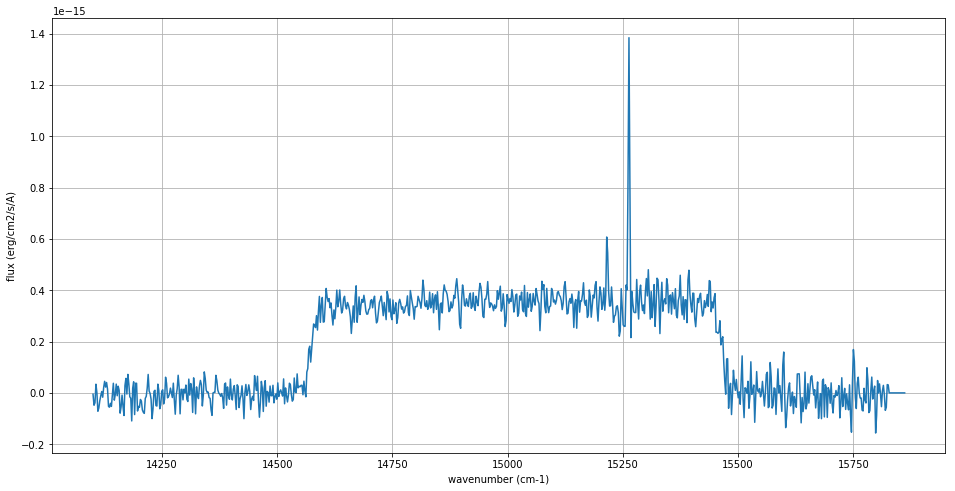

In [9]:
# here we extract the integrated spectrum from a circular aperture centered on the pixel 919, 893 with a radius of 2 pixels
axis, spectrum = cube.extract_spectrum(919, 893, 2)
pl.figure(figsize=(16, 8))
pl.plot(axis, spectrum)
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('flux (erg/cm2/s/A)')
pl.grid()

### squared aperture (binning)

`cube.extract_spectrum_bin(x, y, b)`

* x, y: pixel position of the **bottom-left corner** (in pixels)
* b: binning or square size (in pixels)

### irregular region

`cube.extract_integrated_spectrum(region)`

* region: can be a list of pixels or a **ds9 region file path**

In [28]:
# first of all the deep frame of the cube must be extracted (aling with the WCS)
df = cube.get_deep_frame()
hdr = cube.get_wcs_header()
orb.utils.io.write_fits('deep_frame_wcs.fits', df, fits_header=hdr, overwrite=True)

next|INFO| Data written as deep_frame_wcs.fits in 0.23 s 


'deep_frame_wcs.fits'

The deep frame can be downloaded with JupyterLab easily. A region can be created and saved in a ds9 region file. You can choose to save it with image coordinates or celestial coordinates (fk5). I did both for a circular aperture around (919, 893) and obtained:

warning : **ds9 pixels starts at 1, i.e. : the object at 919, 893 in the spectral cube is at 920, 894 in ds9**

* `ds9-pix.reg`
```bash
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
image
circle(920,894,2)
```

* `ds9-fk5.reg`
```bash
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
circle(0:42:48.9232,+41:15:24.000,0.647")
```

These files can be uploaded to your session with
```bash
scp -p 443 ds9-pix.reg login@celeste.phy.ulaval.ca:~/
```

 loading region: Shape : circle ( HMS(0:42:48.9232),DMS(+41:15:24.000),Ang(0.647") )

next|INFO| Number of integrated pixels: 11




 [==========] [100%] [completed in 0.014 s]
 [==========] [100%] [completed in 0.001 s]
 loading region: Shape : circle ( Number(920),Number(894),Number(2) )

next|INFO| Number of integrated pixels: 13




 [==========] [100%] [completed in 0.031 s]
 [==========] [100%] [completed in 0.002 s]


next|INFO| Number of integrated pixels: 13


 [==========] [100%] [completed in 0.013 s]
 [==========] [100%] [completed in 0.001 s]


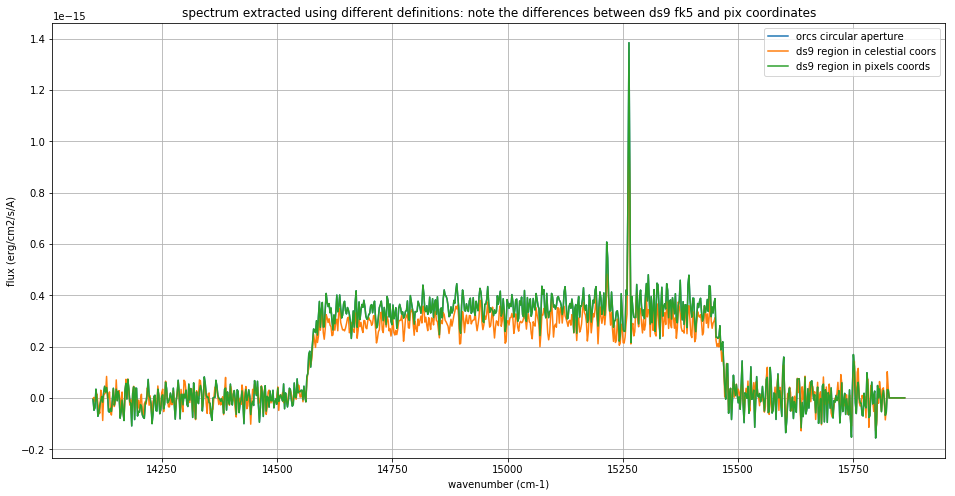

In [42]:
# here we extract the integrated spectrum from a region defined with ds9 in pixels
axis, spectrum_fk5 = cube.extract_integrated_spectrum('data/ds9-fk5.reg')
axis, spectrum_pix = cube.extract_integrated_spectrum('data/ds9-pix.reg')
axis, spectrum = cube.extract_spectrum(919, 893, 2)

pl.figure(figsize=(16, 8))
pl.plot(axis, spectrum, label='orcs circular aperture')
pl.plot(axis, spectrum_fk5, label='ds9 region in celestial coors')
pl.plot(axis, spectrum_pix, label='ds9 region in pixels coords')
pl.legend()
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('flux (erg/cm2/s/A)')
pl.grid()
pl.title('spectrum extracted using different definitions: note the differences between ds9 fk5 and pix coordinates')

## Fitting a spectrum

A lot of information on the different parameters of the fitting function can be found here: http://celeste.phy.ulaval.ca/orcs-doc/introduction.html

When a spectrum is fitted, it is **extracted and fitted**, so that the **extraction methods are all available with the fitting methods**:

### circular aperture

`cube.fit_lines_in_spectrum(x, y, r, *fit_parameters)`

* x, y: pixel position of the **center** (in pixels)
* r: radius (in pixels)

### squared aperture (binning)

`cube.fit_lines_in_spectrum_bin(x, y, b, *fit_parameters)`

* x, y: pixel position of the **bottom-left corner** (in pixels)
* b: binning or square size (in pixels)

### irregular region

`cube.fit_lines_in_integrated_region(region, *fit_parameters)`

* region: can be a list of pixels or a **ds9 region file path**

next|INFO| Number of integrated pixels: 13


 [==========] [100%] [completed in 0.014 s]
 [==========] [100%] [completed in 0.001 s]

===== Results ======
Velocity:  [-507.1(1.2) -507.1(1.2)]
Flux:  [1.170(50)e-15 2.93(50)e-16]


(14500, 15500)

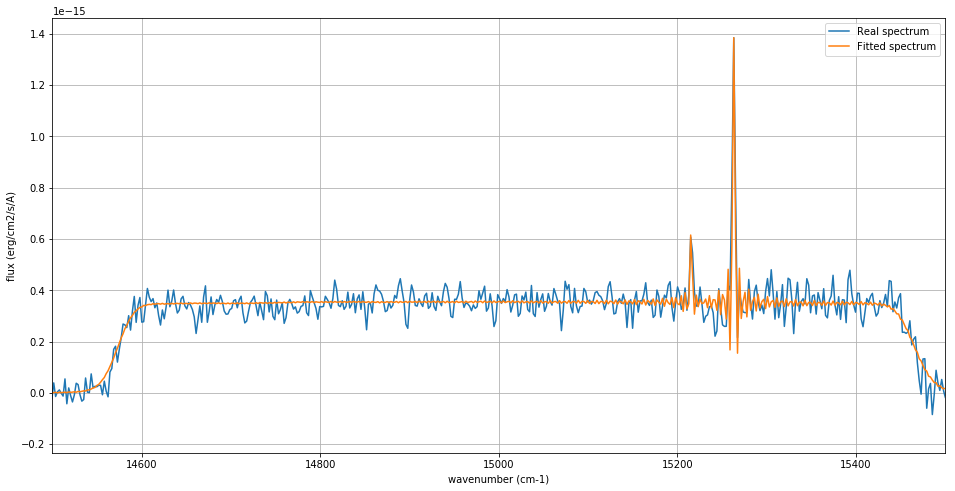

In [43]:
axis, spectrum, fit_res = cube.fit_lines_in_spectrum(919, 893, 2, 
                                                     ['Halpha', '[NII]6583'], # emission lines
                                                     fmodel='sinc', # line model
                                                     pos_cov=-513, # input velocity in km/s
                                                     pos_def=['1', '1']) # both lines share the same velocity
print '\n===== Results ======'
print 'Velocity: ', fit_res['velocity_gvar']
print 'Flux: ', fit_res['flux_gvar']
print '===================='

pl.figure(figsize=(16, 8))
pl.plot(axis, spectrum, label='Real spectrum')
pl.plot(axis, fit_res['fitted_vector'], label='Fitted spectrum')
pl.legend()
pl.grid()
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('flux (erg/cm2/s/A)')
pl.xlim((14500, 15500))

## Fit parameters

The fitting model can be controlled precisely with ORCS. A complete explanation can be found here : http://celeste.phy.ulaval.ca/orcs-doc/introduction.html

A `sinc` emission line has 3 parameters:

* amplitude: `amp`
* velocity:`pos`
* fwhm: `fwhm`

Each fitting parameter can be controlled via its:

* definition: `_def`
* input value: `_guess`
* covarying input values: `_cov`

the possible keywords are then:

* `amp_def`
* `amp_guess`
* `amp_cov`
* `pos_def`
* `pos_guess`
* `pos_cov`
* ...

### parameters definition

Each parameter can be set to :

* `'fixed'`
* `'free'`
* **labeled**: e.g. `'1'` (the number has no importance as long as it is the same for each group of lines)

If we have three emission lines`['Halpha', '[NII]6548', '[NII]6584']`, the definition of the velocity can be e.g.:

* `'pos_def'=('free', '1', '1')`: Halpha velocity is 'free', both NII lines share the same velocity.
* `'fwhm_def'='fixed'`: All lines have a fixed fwhm (default)
* `'pos_def'='2'`: All lines have the same velocity

Note that all lines can have the same fwhm but different velocities.


### covarying parameters

the same line parameter can be set to be covarying between different lines. It means that a given set of lines have the same velocity, or the same fwhm, or a given amplitude ratio (not the same amplitude). 

The input value of the parameter will thus be fixed and only the covarying value will change. e.g.:

`'amp_def' = ('free', '1', '1')` : NII lines have a caovarying amplitude
`'amp_guess' = (1, 1, 3)`: the initial ratio of the NII lines is 3 to 1 (the initial guess in the amplitude of both lines will be kept but will then be multiplied by the same amplitude parameter)
`'amp_cov' = 1e-18`: only one value because there is only one group of lines (the group labeled '1'). The initial value of the amplitude of the NII lines will be : 1e-18 and 3e-18. Onky the covariant parameter will change during the fit.




## Working with WCS

Convert pixel positions to celestial coordinates. This is useful when comparing spectra from two different data cubes (e.g. same object but different filters)

In [24]:
print 'x:919, y:893 in celestial coordinates (degrees): ', cube.pix2world([919, 893]) # in degrees
print 'x:919, y:893 in celestial coordinates (HMS, DMS): \n', cube.pix2world([919, 893], deg=False) # in hms, dms
print 'pixel coordinates of the object at ra:10.70384676 dec:41.25666675', cube.world2pix([10.70384676, 41.25666675])


x:919, y:893 in celestial coordinates (degrees):  [[10.70384676 41.25666675]]
x:919, y:893 in celestial coordinates (HMS, DMS): 
[[ 0.         42.         48.92322326]
 [41.         15.         24.00029889]]
pixel coordinates of the object at ra:10.70384676 dec:41.25666675 [[919.00003003 893.00000418]]
